<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/midpoint_to_coo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install sweetviz
import sweetviz as sv
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import io
from google.colab import files
uploaded = files.upload()

Saving assumed_PHA.csv to assumed_PHA.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['assumed_PHA.csv']))
df.fillna(df.median(),
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MID_POINT_X,MID_POINT_Y,Area,long,lat
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442


In [3]:
print(df.columns)

Index(['X1', 'Y1', 'X2', 'Y2', 'MID_POINT_X', 'MID_POINT_Y', 'Area', 'long',
       'lat'],
      dtype='object')


In [4]:
df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',},
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442


In [5]:
df.tail()

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat
13,1097,236,1117,274,1107.0,255.0,760,24.921000,67.143724
14,870,274,897,343,883.5,308.5,1863,24.920927,67.143555
15,215,409,264,535,239.5,472.0,6174,24.920873,67.143292
16,270,548,342,689,306.0,618.5,10152,24.920829,67.143271
17,358,536,429,682,393.5,609.0,10366,24.920827,67.143284


In [6]:
df1 = df.head()
df2= df.tail()
conc_data_row = pd.concat([df1, df2],
                          axis=0, # Adds dataframes in row
                          ignore_index=False,)
conc_data_row

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442
13,1097,236,1117,274,1107.0,255.0,760,24.921000,67.143724
14,870,274,897,343,883.5,308.5,1863,24.920927,67.143555
15,215,409,264,535,239.5,472.0,6174,24.920873,67.143292
16,270,548,342,689,306.0,618.5,10152,24.920829,67.143271
17,358,536,429,682,393.5,609.0,10366,24.920827,67.143284


In [0]:
assert df['X1'].notnull().all()
assert df['Y1'].notnull().all()
assert df['X2'].notnull().all()
assert df['Y2'].notnull().all()
assert df['MPX'].notnull().all()
assert df['MPX'].notnull().all()
assert df['Area'].notnull().all()
assert df['long'].notnull().all()
assert df['lat'].notnull().all()

In [8]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep='first',
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 9) Duplicated rows have been removed.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      18 non-null     int64  
 1   Y1      18 non-null     int64  
 2   X2      18 non-null     int64  
 3   Y2      18 non-null     int64  
 4   MPX     18 non-null     float64
 5   MPY     18 non-null     float64
 6   Area    18 non-null     int64  
 7   long    18 non-null     float64
 8   lat     18 non-null     float64
dtypes: float64(4), int64(5)
memory usage: 1.4 KB


In [10]:
my_report = sv.analyze(df)
my_report.show_html("mid_coo_report.html")

:FEATURES DONE:                    |                     | [  0%]   00:04  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!


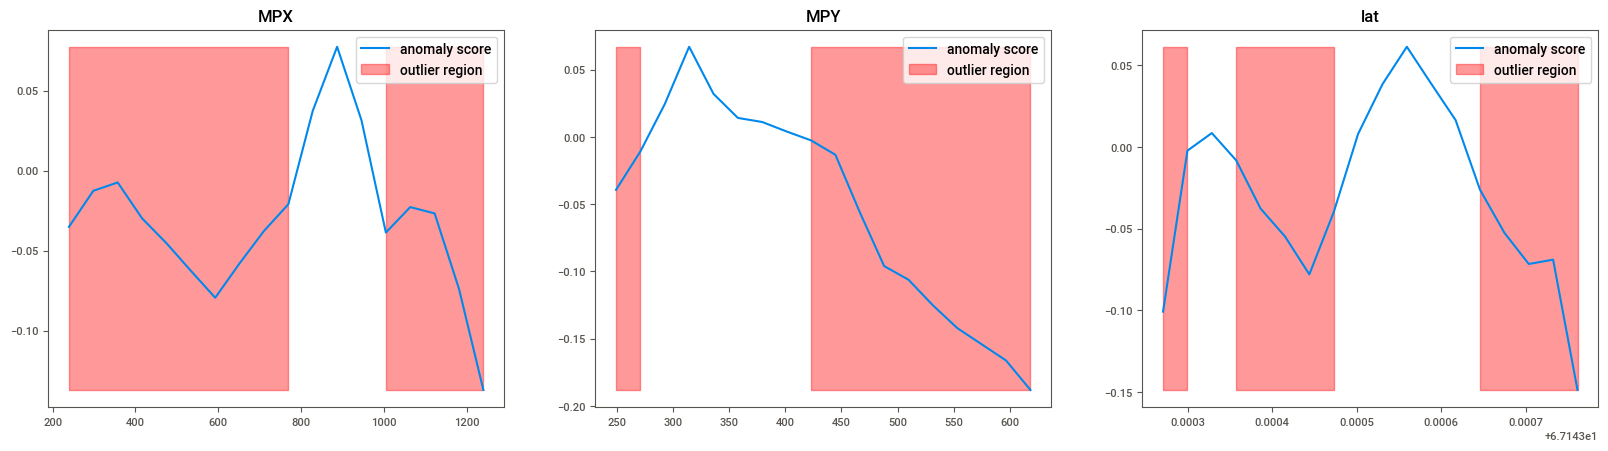

In [11]:
cols = ['MPX',
        'MPY',
        'lat',]
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),
                        facecolor='w',
                        edgecolor='k',)
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(),
                     df[column].max(),
                     len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        np.min(anomaly_score),
                        np.max(anomaly_score), 
                     where=outlier==-1,
                     color='r', 
                     alpha=.4,
                     label='outlier region',)
    axs[i].legend()
    axs[i].set_title(column)

In [0]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)

In [13]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_df)
df_pca.shape

(18, 2)

In [14]:
pca.explained_variance_ratio_

array([0.77872965, 0.19265439])

In [0]:
X = df[['MPX',
        'MPY',]]
y = df['lat']

# Split the data into training/testing sets
X_train = X[:5]
X_test = X[5:]

# Split the targets into training/testing sets
y_train = y[:5]
y_test = y[5:]

In [16]:
X_train.head()

,MPX,MPY
0,320.0,457.0
1,854.5,359.5
2,1239.5,322.5
3,883.5,302.0
4,435.5,330.5


In [17]:
regr = linear_model.LinearRegression()
regr.fit(X_train,
         y_train,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
y_pred = regr.predict(X_test)
print(X_test)
print(y_pred)

       MPX    MPY
5    873.0  455.0
6   1165.0  257.5
7   1000.5  249.0
8    783.5  267.5
9    584.5  291.0
10   241.0  360.5
11  1082.5  334.5
12   819.5  307.0
13  1107.0  255.0
14   883.5  308.5
15   239.5  472.0
16   306.0  618.5
17   393.5  609.0
[67.14342562 67.14365829 67.14363469 67.1435769  67.14351804 67.14339047
 67.14357352 67.14354829 67.14364952 67.14355909 67.14329012 67.14317126
 67.1431964 ]


In [19]:
print('Coefficients: \n',
      regr.coef_,)

print('Mean squared error: %.2f'% mean_squared_error(y_test,
                                                     y_pred),)

print('Coefficient of determination: %.2f'
      % r2_score(y_test,
                 y_pred),)

Coefficients: 
 [ 1.89799316e-07 -8.97473200e-07]
Mean squared error: 0.00
Coefficient of determination: 0.85


In [20]:
regr.predict([[1107,
               255,]])

array([67.14364952])

In [0]:
pickle_out=open("dict1.pickle",
                "wb",)
pickle.dump(regr,
            pickle_out,)

In [0]:
pickle_out.close()

In [23]:
!ls

assumed_PHA.csv  dict1.pickle  mid_coo_report.html  sample_data


In [24]:
!pip freeze | grep scikit-learn

scikit-learn==0.22.2.post1
